In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set() 

# Besoins

Nettoyer les données manquantes, avec une régression linéaire.

Mettre en place un algorithme qui soit capable de différencier automatiquement les vrais des faux billets et, mettre en concurrence deux méthodes  :  
   -  méthode 1 : un k-means
   -  méthode 2 : une régression logistique 

Cet algorithme se devra d’être naturellement le plus performant possible pour identifier un maximum de billets contrefaits au sein de la masse de billets analysés.

Pour une évaluation optimale des modèles, avoir une analyse des nombres de faux positifs et faux négatifs par l'intermédiaire une matrice de confusion et des scores. 

Enfin, tester l'algorithme sur un jeu de données de production.

# I. Observation

**Quelques éléments de contexte :**  
    
La BCE rappelle que 17 billets contrefaits sur 1 million sont en circulation en Europe : https://www.ecb.europa.eu/press/pr/date/2021/html/ecb.pr210122~5b82ddc7b9.fr.html  

Selon la Banque de France, la valeur moyenne d'un billet prélevé au guichet en France est de 26 euros  : https://www.banque-france.fr/billets/analyser-et-anticiper/chiffres-cles-sur-les-billets-et-les-pieces    

## Lecture des données

On créé un dataframe dfB pour lire les caractéristiques des billets

In [2]:
dfB = pd.read_csv('./billets.csv', sep=';', encoding='UTF-8') #pour test sur les billets de production : ./billets_production.csv et dfB.drop("id",axis=1,inplace=True)
dfB.head(2)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09


In [3]:
dfB.shape

(1500, 7)

Pour la détection, une variable sur l'authenticité des billets est présente (is_genuine)

In [4]:
dfB.is_genuine.value_counts()

True     1000
False     500
Name: is_genuine, dtype: int64

Sur 1500 billets dans le dataframe, il existe 1000 vrais billets pour 500 faux billets dans l'échantillon

In [5]:
dfB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


Toutes les variables sont de type float, sauf is_genuine qui est boolèenne

## Qualité des données

#### A. Valeurs manquantes

In [6]:
dfB.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

37 valeurs manquantes sur 1500 dans margin_low (soit environ 3% des données manquantes sur 1/7 des variables)   

In [7]:
dfB.margin_low.describe()

count    1463.000000
mean        4.485967
std         0.663813
min         2.980000
25%         4.015000
50%         4.310000
75%         4.870000
max         6.900000
Name: margin_low, dtype: float64

**Conclusion sur l'observation de la qualité des données :**

Les données fournies sont principalement géométriques et en partie complète : 1/3 de l'échantillon est composé de billets contrefaits (is_genuine = False).

Selon les informations de la BCE et de la Banque de France, on peut estimer que le jeu de données représente :
- une valeur totale de 39 000 € selon la valeur moyenne d'un billet en circulation en France
- qu'un tiers de cet ensemble, soit 13 000 €, est en billets contrefaits  
- et qu'il manque des données sur 3% de la variable margin_low, parmi les 7 variables du jeu de données

En considérant la taille et la valeur de ce jeu de données, l'utilisation à tort des données manquantes de la valeur margin_low représente  : 
- un biais inférieur à l'ordre de 0,5% sur l'ensemble du jeu de données,  
- ou approximativement de l'ordre de 167 € (=1/7 x 0,003 x 39000).



#### B. Traitement des valeurs manquantes : régression linéaire

Pour ne pas supprimer de données de l'échantillon, on remplace les valeurs manquantes : la regréssion linéaire multiple sera adoptée parmi plusieurs approches existantes pour remplacer des données manquantes (cf. C autres méthodes)

Il n'est pas possible d'opérer une régression linéaire sur un jeu de données avec des valeurs manquantes : on sépare le dataframe entre 'Z' où les valeurs margin_low sont absentes (37 entrées) et 'dfB_reg' où les valeurs sont présentes (1463 entrées)

In [8]:
Z = dfB[dfB['margin_low'].isnull()==True]
Z.head(2)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,NaN,3.25,112.79
99,True,171.93,104.07,104.18,NaN,3.14,113.08


In [9]:
dfB_reg = dfB[dfB['margin_low'].isnull()==False]
dfB_reg.head(2)

#dfB_reg = dfB_reg.astype({'is_genuine': 'string'})
#dfB_reg_True = dfB_reg[(dfB_reg['is_genuine']=='True')]
#dfB_reg_False = dfB_reg[(dfB_reg['is_genuine']=='False')]

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09


In [10]:
dfB_reg.is_genuine.value_counts(), dfB_reg.shape

(True     971
 False    492
 Name: is_genuine, dtype: int64,
 (1463, 7))

On remarque que la répartition des vrais / faux billets (2/3, 1/3) dans l'échantillon dfB_reg est respectée à ~1% par rapport à celle de l'échantillon dfB

In [11]:
dfB_reg.isnull().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

**Echantillonage**

On crée un objet **Y** avec la variable à expliquer (variable dépendante)

In [12]:
Y = dfB_reg.margin_low

On crée un objet **X** avec les variables explicatives/indépendantes (sans is_genuine)

In [13]:
X_named = dfB_reg[['diagonal', 'height_left', 'height_right', 'margin_up', 'length']]

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X_named)

In [15]:
from sklearn.model_selection import train_test_split
#Repartition 2/3-1/3 : 67% des données pour l’apprentissage et 33% des données pour l'échantillon test 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.33, random_state = 42)

**Utilisation de la régression linéaire pour la prédiction**

In [16]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression() 

#On modélise avec train (X_train=training data) et y (y_train=target values)
lr.fit(X_train,y_train)  
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.fit

#On prédit les valeurs en utilisant le modéle de régression linéaire avec X_test
y_pred = lr.predict(X_test)
#On affiche les 37 valeurs
y_pred[0:37]

array([4.9859412 , 4.29237811, 4.3601752 , 4.0757229 , 3.995299  ,
       4.09812215, 4.86980629, 4.11701228, 4.17145159, 3.82585911,
       5.15593961, 4.10895634, 4.45387342, 4.07200395, 5.93214056,
       4.09245261, 4.10854275, 3.97896467, 4.1674813 , 5.1041935 ,
       4.2368634 , 4.77675035, 5.03745004, 4.07793264, 4.06297282,
       3.99754059, 4.15823544, 4.09820459, 4.93910165, 4.24968908,
       5.11473382, 4.1504098 , 4.49151386, 4.17918028, 3.97722022,
       4.17139123, 3.97730303])

**Coefficients**

In [17]:
from sklearn.metrics import mean_squared_error, r2_score
print("RMSE : " + str(mean_squared_error(y_test, y_pred, squared= False)))
print("R² : " + str(r2_score(y_test, y_pred)))

RMSE : 0.48266069038019843
R² : 0.4669904280177162


Nous obtenons un score de $R^2$ (coefficient de détermination) d'environ 0,47 ce qui signifie que 47 % de la variable à expliquer (margin_low) peut être expliquée par nos variables explicatives.

Le RMSE (Root Mean Square Error, erreur quadratique moyenne ou racine carrée de la variance des résidus) est proche de 0 : la distance entre les valeurs de données observées et les valeurs de données prédites est faible ce qui donne un indicateur de la pertinence du modèle.

In [18]:
coef = pd.DataFrame(lr.coef_ ,index = X_named.columns, columns=['Coef'])
coef.loc['Constante'] = lr.intercept_
coef

,Coef
diagonal,-0.021924
height_left,0.056048
height_right,0.075892
margin_up,0.061547
length,-0.366640
Constante,4.482303


La constante 'intercept' (valeur d'interception) est la valeur moyenne estimée de notre variable dépendante lorsque toutes les valeurs de nos variables indépendantes sont égales à 0.  

Les coefficients représentent la relation des variables indépendantes avec la variable dépendante (margin_low).
Par exemple, un changement de 1 d'une variable indépendante changera la valeur de notre variable dépendante du même montant que le coefficient. 

**Analyse des résultats de la régression**

L'analyse des résultats et les résidus (linéarité, normalité, homoscédasticité) est faite avec statsmodels

In [19]:
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

In [20]:
reg_ = smf.ols('margin_low~diagonal+height_left+height_right+margin_up+length', data=dfB_reg).fit()
print(reg_.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Wed, 15 Dec 2021   Prob (F-statistic):          2.60e-202
Time:                        16:48:45   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382   

**Tests**

In [21]:
dfB_reg['residus'] = reg_.resid

In [22]:
print('R2 score:', reg_.rsquared)
print('F-statistic:', reg_.fvalue)
print('Probabilité d observer une valeur au moins aussi élevée que F-statistic:', reg_.f_pvalue)

R2 score: 0.4773366973063954
F-statistic: 266.1290985577848
Probabilité d observer une valeur au moins aussi élevée que F-statistic: 2.60059481013516e-202


La différence score $R^2$ avec la régression linéaire de sckit-learn est minime (~1%)  

L'analyse de la variance permet de déterminer si la régression linéaire multiple est plus perfomant que la régression linéaire simple (sur une seule variable dépendante) : nous pouvons évaluer la signification de notre modèle en calculant la probabilité d'observer une statistique F au moins aussi élevée que la valeur obtenue par notre modèle.  

Comme pour le score $R^2$, nous pouvons obtenir la statistique F et la probabilité de cette statistique F avec `.fvalue` et `.f_pvalue`  

Ici, la valeur f_p est inférieure à 0,05 : **nous pouvons conclure que notre modèle est plus performant qu'un autre modèle simple**

**Test de Student**

In [23]:
print(reg_.pvalues)

Intercept       1.736939e-02
diagonal        7.443859e-03
height_left     4.132146e-05
height_right    2.836546e-09
margin_up       7.233463e-05
length          2.183858e-97
dtype: float64


La statistique-t (test de Student) est le coefficient divisé par son erreur standard/erreur type, elle même étant une estimation de l'écart-type du coefficient, c'est-à-dire de la quantité de variation entre les observations.  
Elle peut être considérée comme une mesure de la précision avec laquelle le coefficient de régression est mesuré.   

Ici, nos variables indépendantes ont une p_value inférieure à 0,05, ce qui montre qu'elles n'affectent pas la variable dépendante (margin_low).

In [24]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = reg_.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.0136128990686333,
 1.138260573608249,
 1.230114515556036,
 1.4044037781843624,
 1.576950145366581]

Ici, tous les coefficients sont inférieurs à 10, il n'y a pas de problème de colinéarité des variables

**Normalité des résidus**

p-value du test de Shapiro: ShapiroResult(statistic=0.9857879281044006, pvalue=8.536943374437556e-11)


/Users/nipeti/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


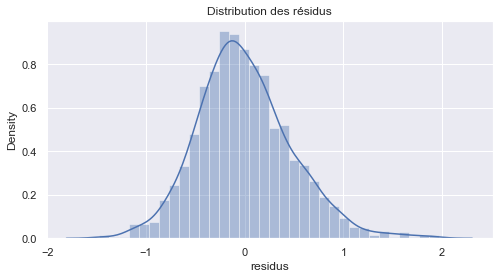

In [25]:
from scipy.stats import shapiro
p_value = shapiro(reg_.resid)
print('p-value du test de Shapiro:', p_value)

# Plotting the residuals distribution
plt.subplots(figsize=(8, 4))
plt.title('Distribution des résidus', fontsize=12)
sns.distplot(dfB_reg['residus'])
plt.show()

Un test de Shapiro présente un p-value proche de 0 indiquant que les résidus ne suivent pas une loi normale (par rapport à un seuil p_value de 0.05)

**Homoscédasticité**

In [26]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 7.759535216217995e-16


L'homoscédascité suppose l'égalité des variances des résidus : elle est vérifiée selon un test de Breusch Pagan  
Ici, nous obtenons p-value proche de 0 : l'hypothèse d’homoscédasticité est rejetée par rapport à un seuil de 0.05.
Pour observer l'hétéroscédascité, nous pouvons tracer notre résidu et voir la forme de la variance.

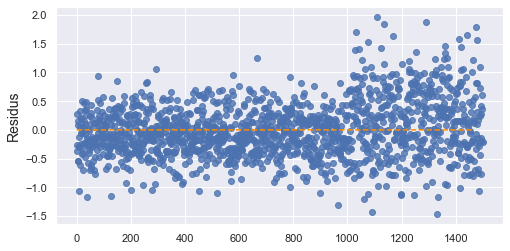

In [27]:
plt.subplots(figsize=(8, 4))
plt.scatter(x=dfB_reg.index, y=reg_.resid, alpha=0.8)
plt.plot(np.repeat(0, len(dfB_reg.index)+2), color='darkorange', linestyle='--')

plt.ylabel('Residus', fontsize=14)
plt.show()  

On pourrait distinguer 2 groupes visuellement à plus ou moins 1000 sur l'index

**Conclusion sur le traitement des valeurs manquantes** :  
Etant donné le $R^{2}$, le RMSE, f_pvalue, p_values des variables indépendantes, ainsi que la nature (vrais/faux billets) et la taille de l'échantillon train (1463) par rapport au test et à la prédiction (37), le modèle de régression linéaire multiple est retenu pour la prédiction des valeurs manquantes sur la variable_margin_low, malgré le fait que les résidus ne soit pas normalement distribués et que la variance des résidus ne soit pas la même pour toutes les observations.  

Pour réaliser dans ce cas une prédiction linéaire multiple pouvant plus probablement vérifier les conditions de normalité des résidus et d'égalité des variances à un seuil p_value > 0.05 : il s'agit d'en réaliser deux sur des jeux de données séparés en fonction des valeurs 'is_genuine' (True/False).

**Concaténation des valeurs (prédiction, observées)**

In [28]:
y_pred = y_pred[0:37]

In [29]:
Z.drop("margin_low",axis=1,inplace=True)

In [30]:
Z['margin_low']= y_pred
Z.head(2)

,is_genuine,diagonal,height_left,height_right,margin_up,length,margin_low
72,True,171.94,103.89,103.45,3.25,112.79,4.985941
99,True,171.93,104.07,104.18,3.14,113.08,4.292378


In [31]:
dfB_reg.drop("residus",axis=1,inplace=True)
dfB_pred = pd.concat([Z, dfB_reg], axis=0)
dfB_pred.head(2)

,is_genuine,diagonal,height_left,height_right,margin_up,length,margin_low
72,True,171.94,103.89,103.45,3.25,112.79,4.985941
99,True,171.93,104.07,104.18,3.14,113.08,4.292378


In [32]:
dfB_pred.isnull().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_up       0
length          0
margin_low      0
dtype: int64

In [33]:
dfB_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 72 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_up     1500 non-null   float64
 5   length        1500 non-null   float64
 6   margin_low    1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 83.5 KB


In [34]:
dfB_pred.isnull().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_up       0
length          0
margin_low      0
dtype: int64

In [35]:
dfB_pred.margin_low.describe()

count    1500.000000
mean        4.483089
std         0.659795
min         2.980000
25%         4.020000
50%         4.310000
75%         4.870000
max         6.900000
Name: margin_low, dtype: float64

In [36]:
dfB.margin_low.describe()

count    1463.000000
mean        4.485967
std         0.663813
min         2.980000
25%         4.015000
50%         4.310000
75%         4.870000
max         6.900000
Name: margin_low, dtype: float64

On observe que les valeurs statistiques obtenues avec la prédiction sont proches (à moins d'1% près sur la moyenne et l'écart-type) de celles de l'échantillon d'origine (dfB)

In [37]:
dfB = dfB_pred
dfB.head(2)

,is_genuine,diagonal,height_left,height_right,margin_up,length,margin_low
72,True,171.94,103.89,103.45,3.25,112.79,4.985941
99,True,171.93,104.07,104.18,3.14,113.08,4.292378


#### C. Autres méthodes

In [38]:
#X = dfB[['margin_low']]

In [39]:

#Méthode KNN Imputer, pour trouver la valeur manquante de la colonne, prendre les caractéristiques des voisins
#from sklearn.impute import KNNImputer
#imputer = KNNImputer(n_neighbors=2, weights="distance")
#X = pd.DataFrame(imputer.fit_transform(X), columns = X.columns)
#X.rename(columns={'margin_low': 'margin_low_filled'}, inplace=True)
#dfB = pd.concat([X['margin_low_filled'], dfB], axis=1)
#dfB.drop('margin_low', axis=1, inplace=True)
#dfB.rename(columns={'margin_low_filled': 'margin_low'}, inplace=True)
#order = [1,2,3,4,0,5,6] # paramétrage de l'ordre des colonnes
#dfB = dfB[[dfB.columns[i] for i in order]]
#dfB.head(1)


In [40]:

#Methode interpolation
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html
#dfB.margin_low.interpolate(method='polynomial', order=2,limit=None, inplace=True)


In [41]:

#Methode pour un remplacement par la moyenne des données de la variable
#dfB.margin_low.fillna(dfB.margin_low.mean(), inplace=True)


## Corrélation

#### Pairplot

On représente les relations par paires sur le dataframe dfB, avec les données booléenne de la variable 'is_genuine' en couleurs

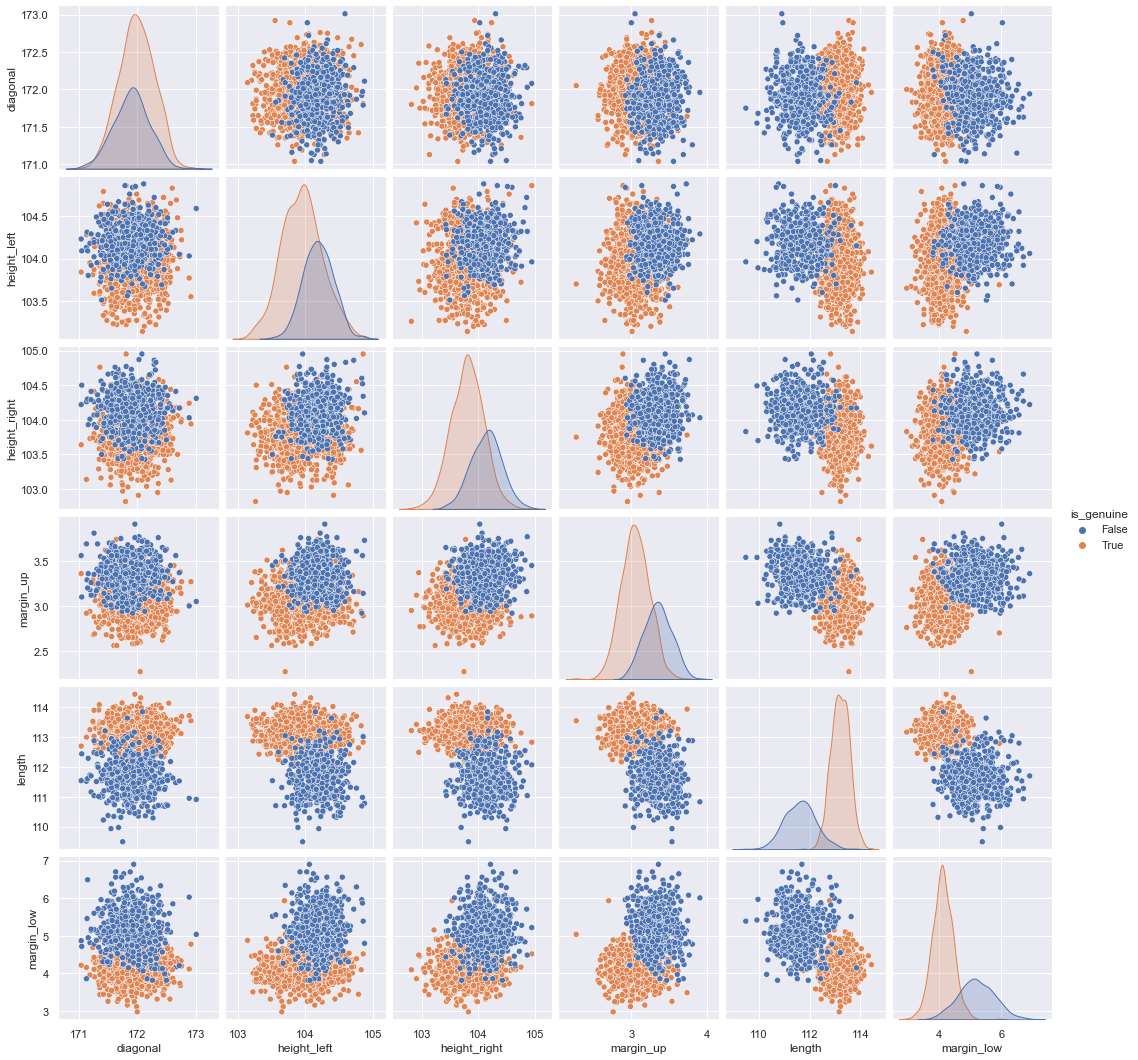

In [42]:
sns.pairplot(dfB, hue='is_genuine')

On observe que les centres des distributions des variables 'margin_low', 'margin_up' et 'length' se distinguent selon les données de la variable 'is_genuine'.  
Ces variables *peuvent* s'avérer significatives pour la détection de vrais/faux billets.

#### Matrices

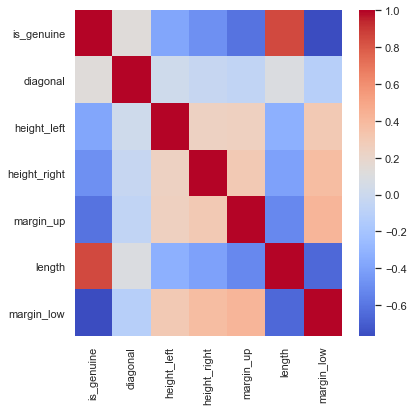

In [43]:
sns.set(rc={'figure.figsize':(6,6)})

df_corr = dfB.corr()

ax = sns.heatmap(df_corr, xticklabels = dfB.columns , 
                 yticklabels = dfB.columns, cmap = 'coolwarm')

In [44]:
cm = sns.light_palette("green", as_cmap=True) 

pd.DataFrame(dfB.corr()).\
style.background_gradient(cmap=cm).set_precision(2)

,is_genuine,diagonal,height_left,height_right,margin_up,length,margin_low
is_genuine,1.00,0.13,-0.38,-0.49,-0.61,0.85,-0.77
diagonal,0.13,1.00,0.02,-0.02,-0.06,0.10,-0.11
height_left,-0.38,0.02,1.00,0.24,0.25,-0.32,0.30
height_right,-0.49,-0.02,0.24,1.00,0.31,-0.40,0.38
margin_up,-0.61,-0.06,0.25,0.31,1.00,-0.52,0.42
length,0.85,0.10,-0.32,-0.40,-0.52,1.00,-0.65
margin_low,-0.77,-0.11,0.30,0.38,0.42,-0.65,1.00


Les matrices mettent en évidence une corrélation :  
    - positive significative (supérieure à 0.5) entre **length** et **is_genuine**  
    - negative significative (inférieure à -0.5) entre **margin_low**, **margin_up** et **is_genuine** 

# II. Méthode 1

## Analyse en Composantes Principales

In [45]:
X = dfB.iloc[:,1:7].to_numpy()
X

array([[171.94      , 103.89      , 103.45      ,   3.25      ,
        112.79      ,   4.9859412 ],
       [171.93      , 104.07      , 104.18      ,   3.14      ,
        113.08      ,   4.29237811],
       [172.07      , 103.8       , 104.38      ,   3.02      ,
        112.93      ,   4.3601752 ],
       ...,
       [171.8       , 104.01      , 104.12      ,   3.36      ,
        111.95      ,   5.51      ],
       [172.06      , 104.28      , 104.06      ,   3.46      ,
        112.25      ,   5.17      ],
       [171.47      , 104.15      , 103.82      ,   3.37      ,
        112.07      ,   4.63      ]])

Les données sont centrées réduites pour réaliser l'ACP, afin que les moyennes soient toutes égales et que les variances le soient aussi

In [46]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
XCR = scaler.fit_transform(X)

In [47]:
from fanalysis.pca import PCA

In [48]:
my_pca = PCA(std_unit=True, row_labels=dfB.index.values, col_labels=dfB.columns.values[1:7])

In [49]:
my_pca.fit(XCR)

PCA(col_labels=array(['diagonal', 'height_left', 'height_right', 'margin_up', 'length',
       'margin_low'], dtype=object),
    row_labels=array([  72,   99,  151, ..., 1497, 1498, 1499]))

**Analyse des valeurs propres**

[[  2.57357674   1.01730152   0.78125863   0.7099005    0.58619317
    0.33176944]
 [ 42.89294569  16.9550253   13.02097722  11.83167507   9.7698861
    5.52949061]
 [ 42.89294569  59.847971    72.86894822  84.70062329  94.47050939
  100.        ]]


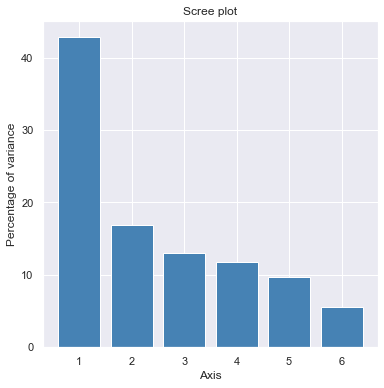

In [50]:
print(my_pca.eig_)
my_pca.plot_eigenvalues(type="percentage")

**Extraction des statistiques**

In [51]:
df_rows = my_pca.row_topandas()
df_rows.head(2)

,row_coord_dim1,row_coord_dim2,row_coord_dim3,row_coord_dim4,row_coord_dim5,row_coord_dim6,row_contrib_dim1,row_contrib_dim2,row_contrib_dim3,row_contrib_dim4,row_contrib_dim5,row_contrib_dim6,row_cos2_dim1,row_cos2_dim2,row_cos2_dim3,row_cos2_dim4,row_cos2_dim5,row_cos2_dim6
72,0.217785,-0.408452,0.341728,-1.467797,-0.472829,-0.614517,0.001229,0.010933,0.009965,0.202322,0.025426,0.075882,0.015366,0.054049,0.037833,0.697978,0.072430,0.122343
99,0.042195,0.084224,-0.131665,0.829434,0.461656,-0.184298,0.000046,0.000465,0.001479,0.064606,0.024238,0.006825,0.001852,0.007380,0.018034,0.715685,0.221715,0.035334


Ce sont les coordonnées des lignes qui seront retenues pour les composantes principales (synthétiques)

In [52]:
df_cols = my_pca.col_topandas()
df_cols.head(2)

,col_coord_dim1,col_coord_dim2,col_coord_dim3,col_coord_dim4,col_coord_dim5,col_coord_dim6,col_contrib_dim1,col_contrib_dim2,col_contrib_dim3,col_contrib_dim4,col_contrib_dim5,col_contrib_dim6,col_cos2_dim1,col_cos2_dim2,col_cos2_dim3,col_cos2_dim4,col_cos2_dim5,col_cos2_dim6
diagonal,0.135697,0.949609,0.254079,-0.087254,-0.087508,-0.001328,0.715493,88.642092,8.263092,1.072449,1.306342,0.000532,0.018414,0.901757,0.064556,0.007613,0.007658,0.000002
height_left,-0.534170,0.309200,-0.781999,-0.041780,0.075731,-0.007452,11.087184,9.397852,78.273950,0.245887,0.978390,0.016738,0.285337,0.095604,0.611522,0.001746,0.005735,0.000056


**Etude des liaisons entre les variables**

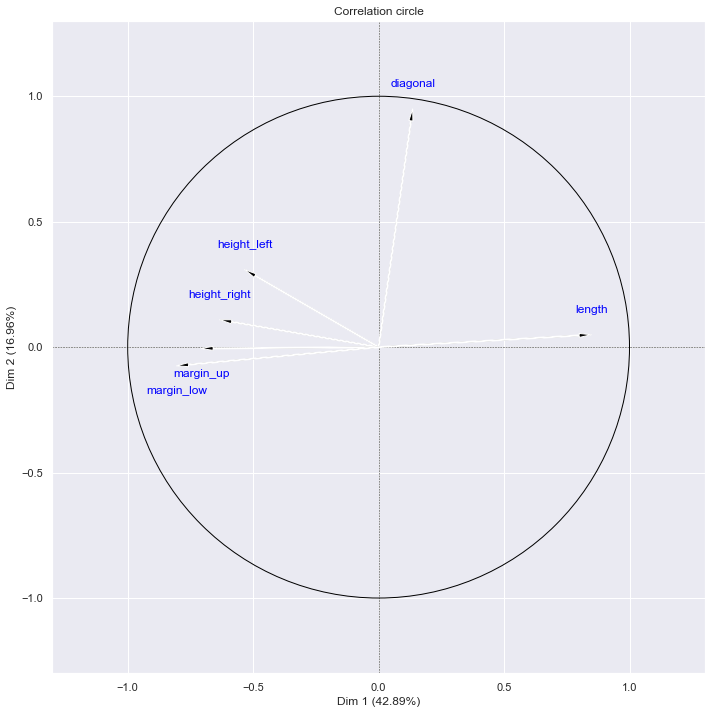

In [53]:
my_pca.correlation_circle(1, 2, figsize=(14, 12))

On observe :   
    - la variable 'length' tend positivement selon la dimension 1  
    - la variable 'diagonal' tend positivement selon la dimension 2  
    - les variables 'margin' et 'height' tendent négativement selon la dimension 1  

Avec 2 dimensions, près de 60 % de l'information est conservée

**Etudier la variabilité**

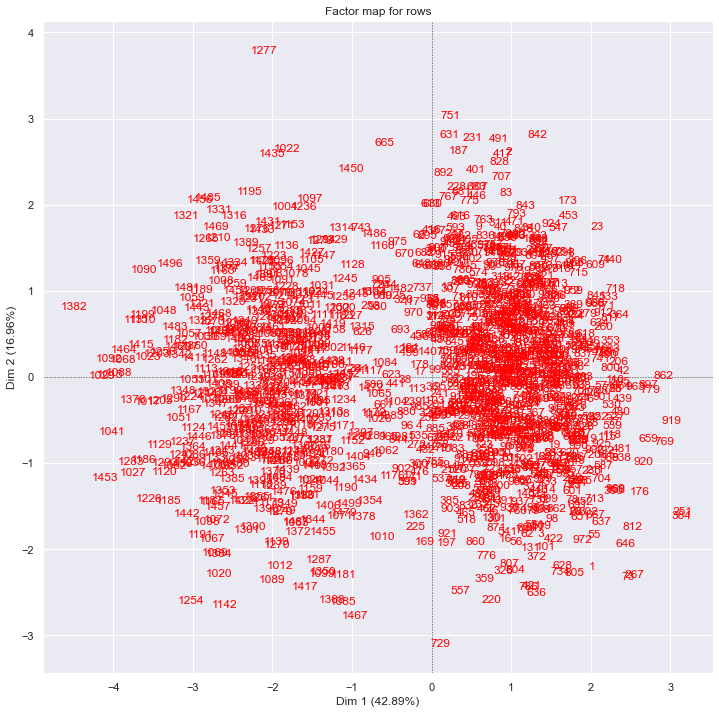

In [54]:
my_pca.mapping_row(num_x_axis=1, num_y_axis=2, figsize=(12, 12))

**Analyse des axes**

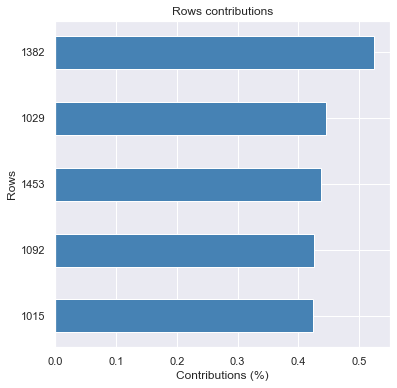

In [55]:
my_pca.plot_row_contrib(num_axis=1, nb_values=5)

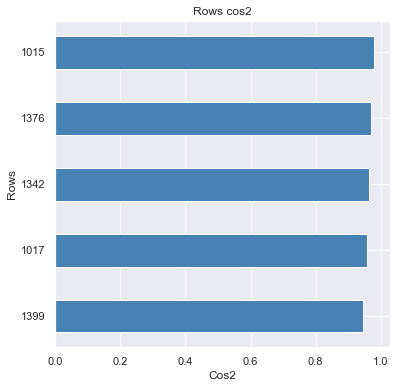

In [56]:
my_pca.plot_row_cos2(num_axis=1, nb_values=5)

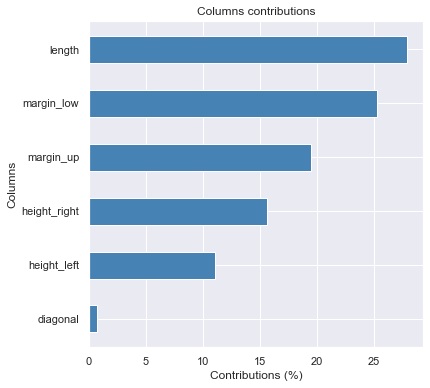

In [57]:
my_pca.plot_col_contrib(num_axis=1)

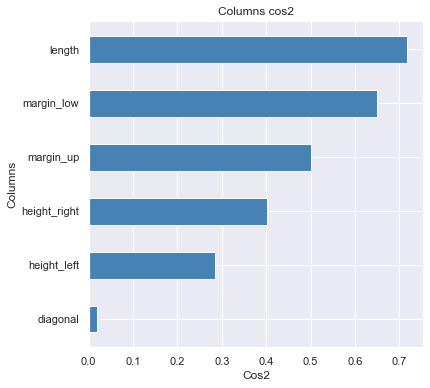

In [58]:
my_pca.plot_col_cos2(num_axis=1)

In [59]:
df_ACP = df_rows.iloc[:,0:6]
df_ACP.rename(columns={'row_coord_dim1': 'PC1',
                      'row_coord_dim2': 'PC2',
                       'row_coord_dim3': 'PC3',
                       'row_coord_dim4': 'PC4',
                       'row_coord_dim5': 'PC5',
                       'row_coord_dim6': 'PC6',
                      }, inplace=True)
df_ACP.head(2)

,PC1,PC2,PC3,PC4,PC5,PC6
72,0.217785,-0.408452,0.341728,-1.467797,-0.472829,-0.614517
99,0.042195,0.084224,-0.131665,0.829434,0.461656,-0.184298


**Répartition des dimensions des billets et composition des variables synthètiques**

In [60]:
#n_components
from sklearn import decomposition
pca = decomposition.PCA(n_components=6)
pca.fit(XCR)
Components = pd.DataFrame(df_ACP, index=dfB.index, columns=["PC"+str(i+1) for i in range(6)])
Components.head(2)

,PC1,PC2,PC3,PC4,PC5,PC6
72,0.217785,-0.408452,0.341728,-1.467797,-0.472829,-0.614517
99,0.042195,0.084224,-0.131665,0.829434,0.461656,-0.184298


In [61]:
dfB.columns[1:7]

Index(['diagonal', 'height_left', 'height_right', 'margin_up', 'length',
       'margin_low'],
      dtype='object')

In [62]:
PC1 = pca.components_[0]
PC1

array([-0.08458681,  0.33297423,  0.39496429,  0.44117883, -0.52830946,
        0.50222186])

**PC1** est une combinaison linéaire de  :  
- -0.085 * Diagonal   
- 0.33 * height_left  
- 0.39 * height_right  
- 0.44 * margin_low    
- -0.53 * margin_up  
- 0.50 * length  

et ainsi de suite pour les autres composantes.

In [63]:
PC2 = pca.components_[1]
PC2

array([ 0.94149929,  0.30655916,  0.10831496, -0.00517892,  0.04901179,
       -0.07375266])

In [64]:
PC3 = pca.components_[2]
PC3

array([-0.28745595,  0.88472566, -0.16226995, -0.27077748,  0.14994858,
       -0.11177221])

In [65]:
PC4 = pca.components_[3]
PC4

array([-0.10355911, -0.04958697,  0.87017983, -0.43358046,  0.17637419,
       -0.10248824])

In [66]:
PC5 = pca.components_[4]
PC5

array([ 0.11429534, -0.0989136 , -0.21997749, -0.70881494, -0.27328498,
        0.59300867])

In [67]:
PC6 = pca.components_[5]
PC6

array([0.00230574, 0.0129376 , 0.01834427, 0.20396898, 0.76825116,
       0.60636425])

**Les résultats de l'ACP (composantes) sont utilisées pour le k-means. Les données sont déjà centrées et réduites.**

## K-Means (basé sur l'ACP)

In [68]:
X = df_ACP

In [69]:
from matplotlib.patches import Ellipse
K = np.arange(2,10,1)
K

array([2, 3, 4, 5, 6, 7, 8, 9])

In [70]:
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
for k in K:
    km_char = KMeans(n_clusters=k)
    km_char = km_char.fit(X)
    Sum_of_squared_distances.append(km_char.inertia_)
    
print(Sum_of_squared_distances)

[5839.983183494768, 5125.685122487781, 4710.145671028576, 4393.678371033674, 4141.202948093956, 3952.8257224589624, 3771.4901036719834, 3628.04002381607]


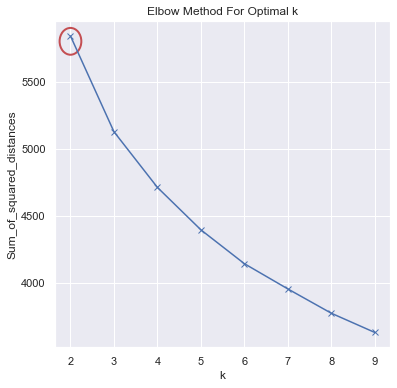

In [71]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.xticks(np.arange(2, 10, step=1))
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')

#On affiche l'ellipse pour Optimal K
ax = plt.gca()

ellipse = Ellipse(xy=(2, 5800), width=0.5, height=200, edgecolor='r', fc='None', lw=2)
ax.add_patch(ellipse)

Bien qu'un "coude" apparait pour k=3, k=2 serait retenu pour ne pas introduire de partitions supplémentaires par rapport à la  variable booléenne 'is_genuine'

In [72]:
#on lance la fonction K-means et on souhaite K classes
result = KMeans(n_clusters=2, random_state=42).fit(X)
#Affichage des classes
print(result.labels_)

[1 1 1 ... 0 0 0]


In [73]:
#Affichage des centres des classes
print(result.cluster_centers_)

[[-2.05153522 -0.07537918  0.0928811  -0.08860259 -0.1293311   0.06182427]
 [ 1.01656331  0.0373514  -0.04602383  0.04390378  0.0640853  -0.03063476]]


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

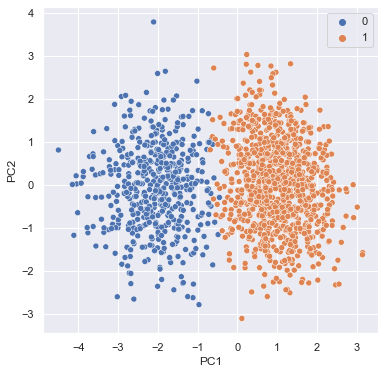

In [74]:
clusters = result.labels_
sns.scatterplot(data=X, x='PC1', y='PC2', hue=result.labels_)

#ou
#colors = ['royalblue', 'deeppink', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'navy']
#vectorizer = np.vectorize(lambda x: colors[x % len(colors)])

#plt.scatter(X['PC1'], X['PC2'], c=result.labels_, s=50, cmap='viridis')
#centers = result.cluster_centers_
#plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [75]:
df_ACP['kmeans'] = result.labels_
df_ACP.head(3)

,PC1,PC2,PC3,PC4,PC5,PC6,kmeans
72,0.217785,-0.408452,0.341728,-1.467797,-0.472829,-0.614517,1
99,0.042195,0.084224,-0.131665,0.829434,0.461656,-0.184298,1
151,0.224658,0.292987,0.794945,1.544941,-0.019836,-0.009577,1


In [76]:
from sklearn.metrics import silhouette_score
silhouette_score(df_ACP[["PC1","PC2"]],result.labels_ )

0.5352282076211016

Le score silhouette indique que le chevauchement des clusters est plus proche de 1 que de 0, la qualité du partitionnement pour cette classification est correcte sans être optimale.

In [77]:
#Fonction pour croiser des variables qualitatives et quantitatives en fonction d'une variable qualitative

def build_plot(explicative,a_expliquer,dfdata, nb_colors = 3):

    import numpy as np # pour gestion des listes
    import pandas as pd #pour manipuler les données / data framed
    import matplotlib.pyplot as plt #pour les sorties graphiques
    import seaborn as sns #pour les sorties graphiques

    #Charte graphique
    colors = [(0/255, 48/255, 73/255), (158/255, 183/255, 208/255), 
          (60/255, 213/255, 229/255), (126/255, 224/255, 74/255),
          (244/255, 96/255, 54/255), (186/255, 43/255, 52/255),
          (230/255, 80/255, 20/255)]

    colorsmod = [(45/255, 125/255, 160/255), (12/255, 80/255, 125/255),
             (0/255, 48/255, 73/255), (158/255, 183/255, 208/255),
             (60/255, 213/255, 229/255), (126/255, 224/255, 74/255)
             , (244/255, 96/255, 54/255), (18/255, 180/255, 152/255),
             (186/255, 43/255, 52/255), (230/255, 80/255, 20/255)]

    if (np.issubdtype(dfdata[explicative].dtype, np.number)) :
        plt.figure(figsize=(6,3))
        sns.boxplot(data=dfdata,x=explicative,y=a_expliquer,palette=colors[0:nb_colors],orient="h")
        plt.xlabel(explicative,fontsize=10)
        plt.ylabel(a_expliquer,fontsize=10)
        plt.title(explicative + " selon " + a_expliquer,fontsize=15)
    else :
        pd.crosstab(dfdata[a_expliquer], dfdata[explicative])\
        .apply(lambda r: r/r.sum(), axis=1).plot(kind='barh',stacked=True,legend=False, color=colorsmod,  figsize=(12,4))
        plt.figure(figsize=(6,3))
        plt.xlabel(explicative,fontsize=10)
        plt.ylabel(a_expliquer,fontsize=10)
        plt.title(explicative + " selon " + a_expliquer,fontsize=15)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

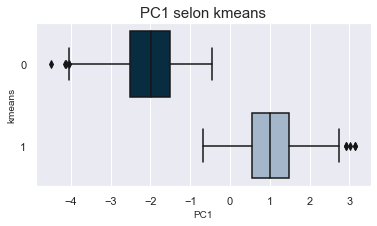

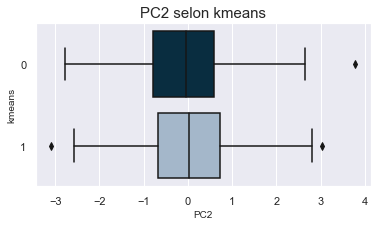

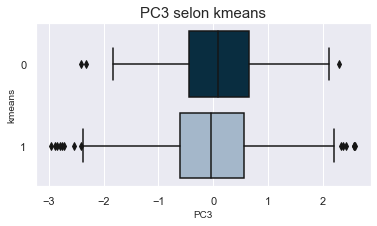

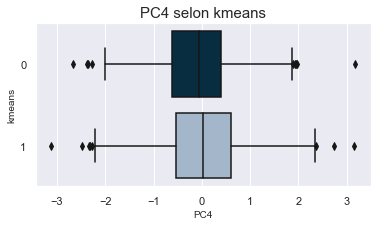

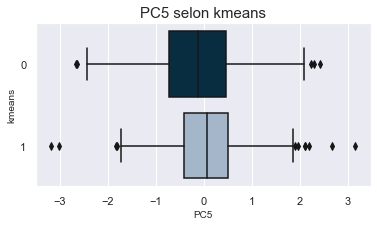

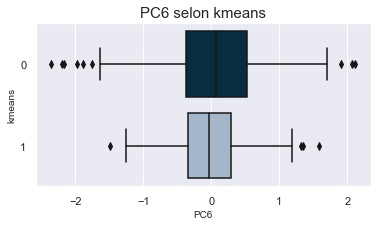

In [78]:
for item in ['PC1','PC2', 'PC3', 'PC4', 'PC5', 'PC6']:
    build_plot(explicative=item,a_expliquer="kmeans",
               dfdata=df_ACP,
               nb_colors=3)

On observe que seule la moyenne des individus des kmeans 0 et 1 de PC1 est visiblement différente

Ensuite, on rapatrie la colonne is_genuine sur le dataframe de l'ACP pour faire correspondre les k-means avec les données sur l'authenticité

In [79]:
df_is_genuine = dfB.iloc[:,0:1]
df_is_genuine.head(1)

,is_genuine
72,True


In [80]:
df = pd.concat([df_is_genuine['is_genuine'], df_ACP], axis=1)

In [81]:
df.head(10)

,is_genuine,PC1,PC2,PC3,PC4,PC5,PC6,kmeans
72,True,0.217785,-0.408452,0.341728,-1.467797,-0.472829,-0.614517,1
99,True,0.042195,0.084224,-0.131665,0.829434,0.461656,-0.184298,1
151,True,0.224658,0.292987,0.794945,1.544941,-0.019836,-0.009577,1
197,True,0.192418,-1.919154,0.929855,-0.781554,1.971702,-0.532156,1
241,True,0.100873,-0.197164,-0.559391,0.656124,0.115670,0.832946,1
251,True,3.151653,-1.565124,1.182755,-2.213857,-1.038986,0.150870,1
284,True,0.332124,-0.386940,0.525755,-0.465827,-0.075809,-0.945163,1
334,True,1.268110,-0.576283,0.535350,0.675566,0.037856,-0.117424,1
410,True,1.470528,1.453676,1.140784,-1.087557,-0.335946,0.107074,1
413,True,1.664307,0.624312,1.056326,-1.037238,0.167937,0.394700,1


Kmeans 1 semble correspondre aux billets is_genuine = True  
Comparons les données classifiées avec le kmeans aux données de is_genuine avec une matrice de confusion

#### A. Matrice de confusion

Pour rappel : 

![matricedeconfusion](https://user.oc-static.com/upload/2017/03/02/14884666421501_P2C1-1.png)

On observe l'appartenance des billets aux classes is_genuine et kmeans

In [82]:
df_cont = pd.crosstab(df.kmeans,df.is_genuine)
df_cont

is_genuine,False,True
kmeans,,
0,487,10
1,13,990


On observe que les billets de kmeans 1 correspondent majoritairement aux billets avec is_genuine = True et les billets de kmeans 0 correspondent majoritairement aux billets avec is_genuine = False  
On obtient donc : 

In [83]:
#Vrai négatif
TN = df_cont.iloc[0,0]
#Vrai positifs
TP = df_cont.iloc[1,1]
#Faux négatif (négatif à tort)
FN = df_cont.iloc[0,1]
#Faux positifs (positif à tort)
FP = df_cont.iloc[1,0]

TN, TP, FN, FP

(487, 990, 10, 13)

Listons les billets de kmeans 0 et 'is genuine' = True (faux positifs) dans un dataframe df_FP

In [84]:
kmeans = [0]
df_FP = df[df['kmeans'].isin(kmeans)].sort_values('is_genuine', ascending=False)
df_FP.head(11)

,is_genuine,PC1,PC2,PC3,PC4,PC5,PC6,kmeans
946,True,-0.742792,-0.890312,0.603777,1.953610,1.279246,0.215880,0
0,True,-1.652804,0.745210,-2.406207,3.179525,0.240346,-0.029994,0
743,True,-0.884120,1.727530,-1.044623,0.206418,0.973834,-0.349914,0
728,True,-1.012676,0.094290,0.185834,0.139184,0.877406,0.987796,0
724,True,-0.645919,1.075355,-0.876382,0.164739,0.248461,-0.095480,0
669,True,-0.622174,0.946078,-0.699946,0.815635,-0.375960,0.133710,0
626,True,-0.866896,0.520690,-1.021952,0.223449,0.262565,-0.295598,0
341,True,-0.906164,0.092965,-0.217980,0.397625,0.881689,-0.947814,0
253,True,-0.767973,0.831094,-0.434610,0.716469,1.352517,-0.806202,0
580,True,-0.730398,-0.088116,-1.311489,-0.072486,1.200762,-0.455372,0


#### B. Score Kmeans

In [85]:
#Calcul d'un score de précision 
#accuracy = (vrais négatifs+vrais positifs) / (vrais négatifs+vrais positifs+faux négatifs+faux positifs)
accuracy = (TN+TP)/(TN+TP+FN+FP)
accuracy

0.9846666666666667

# III. Méthode 2

## Echantillonage

On crée un objet **X** en partant du dataframe dfB pour garder les variables explicatives (hors is_genuine, la variable à expliquer)

In [86]:
X = dfB.iloc[:,1:7]
X.head(1)

,diagonal,height_left,height_right,margin_up,length,margin_low
72,171.94,103.89,103.45,3.25,112.79,4.985941


On crée un objet **Y** avec la variable à expliquer (is_genuine, bool)

In [87]:
Y = dfB.is_genuine
Y.head(1)

72    True
Name: is_genuine, dtype: bool

On regarde la répartition des classes à prédire

In [88]:
Y.value_counts(normalize=True)

True     0.666667
False    0.333333
Name: is_genuine, dtype: float64

On scinde l'échantillon en train / test

In [89]:
from sklearn.model_selection import train_test_split
#66% des données pour l’apprentissage
#33% des données pour l'échantillon test 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.33, random_state = 42, stratify = Y) 
#Pour voir les modèles les plus performants, mettre test_size > 0.9 

On affiche un extrait de *X_train*

In [90]:
print(X_train.shape)
X_train.head(2)

(1005, 6)


,diagonal,height_left,height_right,margin_up,length,margin_low
770,171.80,104.17,103.80,2.88,113.03,4.67
1365,171.74,103.96,103.47,3.30,111.40,5.14


On affiche un extrait de *X_test*.

In [91]:
print(X_test.shape)
X_test.head()

(495, 6)


,diagonal,height_left,height_right,margin_up,length,margin_low
12,171.89,103.89,103.40,2.96,113.24,4.11
405,172.40,104.26,103.83,3.01,112.82,4.31
105,171.85,103.66,103.90,2.98,112.91,4.16
1290,171.94,104.06,104.22,3.36,111.70,6.90
339,172.26,103.88,104.15,2.98,113.24,4.30


On vérifie que les échantillons soient bien stratifiés.

In [92]:
print(y_train.shape)
y_train.value_counts(normalize=True)

(1005,)


True     0.666667
False    0.333333
Name: is_genuine, dtype: float64

In [93]:
print(y_test.shape)
y_test.value_counts(normalize=True)

(495,)


True     0.666667
False    0.333333
Name: is_genuine, dtype: float64

On centre et on réduit les données pour que leurs moyennes soient toutes égales et que leurs variances le soient aussi

In [94]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## Regression logistique

In [95]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

reg_log2 = smf.glm('is_genuine~diagonal+height_left+height_right+margin_low+margin_up+length',
                   data=dfB, family=sm.families.Binomial()).fit()
print(reg_log2.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1500
Model:                                                   GLM   Df Residuals:                     1493
Model Family:                                       Binomial   Df Model:                            6
Link Function:                                         logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -40.636
Date:                                       Wed, 15 Dec 2021   Deviance:                       81.273
Time:                                               16:49:10   Pearson chi2:                 2.78e+03
No. Iterations:                                           10                                         
Covariance Type:                                   nonrobust                      

On observe : 

- Des variables (margin up, margin low, length) ont des p-valeurs qui sont inférieures à un niveau de test de 5 %, ce qui nous indique qu'elles sont bien significatives   

- D'autres (diagonal, height- left, height_right) ne sont pas en dessous de ce seuil.

In [96]:
from sklearn.linear_model import LogisticRegression

reg_log = LogisticRegression()
reg_log_model = reg_log.fit(X_train, y_train)
y_pred = reg_log_model.predict(X_test)
y_pred[0:10]

array([ True,  True,  True, False,  True,  True,  True,  True,  True,
       False])

#### A. Evaluation du modèle et matrice de confusion

On évalue le modèle avec une matrice de confusion entre predictions et observations sur Y test/pred

In [97]:
pd.crosstab(y_test,y_pred, colnames=['observations'], rownames=['predictions'], margins=True)

observations,False,True,All
predictions,,,
False,162,3,165
True,2,328,330
All,164,331,495


ou

In [98]:
from sklearn.metrics import confusion_matrix
mat_conf = pd.DataFrame(confusion_matrix(y_test,y_pred), 
                  columns=['obs_0','obs_1'],
                  index=['pred_0','pred_1'])
mat_conf

,obs_0,obs_1
pred_0,162,3
pred_1,2,328


Sur l'échantillon Y, on obtient :  

In [99]:
#Vrai négatif
TN = mat_conf.iloc[0,0]
#Vrai positifs
TP = mat_conf.iloc[1,1]
#Faux négatif (négatif à tort)
FN = mat_conf.iloc[0,1]
#Faux positifs (positif à tort)
FP = mat_conf.iloc[1,0]

TN, TP, FN, FP

(162, 328, 3, 2)

#### B. Scores Regression logistique

In [100]:
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, f1_score, recall_score, precision_score

print("accuracy : " + str(accuracy_score(y_test,y_pred)))
print('recall_score : ' + str(recall_score(y_test,y_pred,average='binary', pos_label=1)))
print('precision_score : ' + str(precision_score(y_test,y_pred,average='binary', pos_label=1)))
print('f1_score : ' + str(f1_score(y_test,y_pred,average='binary', pos_label=1)))

accuracy : 0.98989898989899
recall_score : 0.9939393939393939
precision_score : 0.9909365558912386
f1_score : 0.9924357034795764


- **La pertinence** permet de connaître la proportion de bonnes prédictions par rapport à toutes les prédictions.

- **Le rappel**, ou le nombre de fois où un billet a été reconnu par rapport au nombre de fois où il aurait dû être reconnu / le nombre de documents correctement attribués à la classe relative par rapport au nombre total de documents appartenant à la classe relative (total true positive)

- **La précision**, ou le nombre de fois où un billet a été reconnu (c’était vraiment lui) par rapport au nombre de fois où il a été prédit (même si ce n’était pas vraiment lui) / le nombre de documents correctement attribués à la classe relative par rapport au nombre total de documents prédits comme appartenant à la classe relative (total predicted positive)

- **Le F1_score**, comme une moyenne harmonique de la précision et du rappel (ne prenant pas en compte le nombre de vrais négatifs)

**Le modèle de régression logistique présente un score "accuracy" quasi-équivalent et légèrement supérieur à celui du kmeans**

#### C. Coefficient de détermination

On s'interesse aux coefficients de détermination de chaque variable :

In [101]:
coef = pd.DataFrame(reg_log_model.coef_[0,] ,index = X.columns, columns=['Coefficient'])
coef.loc['Constante'] = reg_log_model.intercept_
coef

,Coefficient
diagonal,0.301299
height_left,-0.375542
height_right,-0.591325
margin_up,-1.659659
length,3.999388
margin_low,-2.486465
Constante,1.816341


On observe que les valeurs des variables length et margin low sont les plus éloignées de la valeur de la constante

#### D. Estimations des probabilités

predict_proba() renvoie une probabilité des classes auxquelles appartient l'instance, pour autant de lignes que l'échantillon X_test

In [102]:
#Probabilité d'un billet d'appartenir à la classe prédite (pred_0, pred_1), la somme des couples fait 1
reg_log_model.predict_proba(X_test)[0:10].round(3)

array([[0.   , 1.   ],
       [0.011, 0.989],
       [0.003, 0.997],
       [1.   , 0.   ],
       [0.002, 0.998],
       [0.   , 1.   ],
       [0.003, 0.997],
       [0.001, 0.999],
       [0.002, 0.998],
       [1.   , 0.   ]])

In [103]:
#fin